In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# ========================
# 1️⃣ INSTALL & DOWNLOAD DATA
# ========================
!pip install kagglehub nltk

import kagglehub, shutil, pandas as pd, re, numpy as np

path = kagglehub.dataset_download("rishisankineni/text-similarity")
print("Dataset downloaded to:", path)

src_path = path
dst_path = "/content/text-similarity"
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

train_df = pd.read_csv("/content/text-similarity/train.csv")
test_df = pd.read_csv("/content/text-similarity/test.csv")

print("Train:", train_df.shape, "Test:", test_df.shape)

# ========================
# 2️⃣ CLEAN TEXT
# ========================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df.dropna(subset=["description_x", "description_y"], inplace=True)
test_df.dropna(subset=["description_x", "description_y"], inplace=True)

train_df["desc1_clean"] = train_df["description_x"].apply(clean_text)
train_df["desc2_clean"] = train_df["description_y"].apply(clean_text)
test_df["desc1_clean"] = test_df["description_x"].apply(clean_text)
test_df["desc2_clean"] = test_df["description_y"].apply(clean_text)

train_df.to_csv("/content/train_clean.csv", index=False)
test_df.to_csv("/content/test_clean.csv", index=False)
print("✅ Cleaned & Saved")

# ========================
# 3️⃣ LOAD INFERSENT
# ========================
import torch, torch.nn as nn, time, os, zipfile, requests
import nltk
nltk.download('punkt')
from io import BytesIO

# InferSent class (unchanged from your code)
class InferSent(nn.Module):
    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']
        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)
        if self.version == 1:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<s>', '</s>', True, False
        elif self.version == 2:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<p>', '</p>', False, True

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        return word_tokenize(s)

    def get_word_dict(self, sentences):
        word_dict = {}
        for sent in sentences:
            for word in self.tokenize(sent):
                word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v_k(self, K):
        with open(self.w2v_path, encoding='utf-8') as f:
            k, word_vec = 0, {}
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K: break
        return word_vec

    def build_vocab_k_words(self, K):
        self.word_vec = self.get_w2v_k(K)
        print("✅ Vocabulary built")

    def encode(self, sentences, bsize=64):
        sentences = [[self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        lengths = np.array([len(s) for s in sentences])
        idx_sort = np.argsort(-lengths)
        sentences = np.array(sentences, dtype=object)[idx_sort]
        lengths_sorted = lengths[idx_sort]

        def get_batch(batch):
            embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))
            for i in range(len(batch)):
                for j in range(len(batch[i])):
                    embed[j,i,:] = self.word_vec.get(batch[i][j], np.zeros(self.word_emb_dim))
            return torch.FloatTensor(embed)

        embeddings = []
        for i in range(0, len(sentences), bsize):
            batch = get_batch(sentences[i:i+bsize])
            sent_len_sorted = lengths_sorted[i:i+bsize]
            sent_packed = nn.utils.rnn.pack_padded_sequence(batch, sent_len_sorted)
            sent_output = self.enc_lstm(sent_packed)[0]
            sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
            emb = torch.max(sent_output, 0)[0]  # max pooling
            embeddings.append(emb.detach().numpy())

        embeddings = np.vstack(embeddings)
        embeddings = embeddings[np.argsort(idx_sort)]
        return embeddings

# Download models
os.makedirs("fastText", exist_ok=True)
if not os.path.exists("fastText/crawl-300d-2M.vec"):
    r = requests.get("https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip")
    with zipfile.ZipFile(BytesIO(r.content)) as z: z.extractall("fastText/")

os.makedirs("encoder", exist_ok=True)
if not os.path.exists("encoder/infersent2.pkl"):
    r = requests.get("https://dl.fbaipublicfiles.com/infersent/infersent2.pkl")
    open("encoder/infersent2.pkl","wb").write(r.content)

params = {'bsize':64,'word_emb_dim':300,'enc_lstm_dim':2048,'pool_type':'max','dpout_model':0.0,'version':2}
model = InferSent(params)
model.load_state_dict(torch.load("encoder/infersent2.pkl", map_location=torch.device('cpu')))
model.set_w2v_path("fastText/crawl-300d-2M.vec")
model.build_vocab_k_words(100000)

train_df = pd.read_csv("/content/train_clean.csv")
test_df = pd.read_csv("/content/test_clean.csv")

# ========================
# 4️⃣ ENCODING SENTENCES
# ========================

subset = 500  # change to len(train_df) when ready
s1 = train_df['desc1_clean'].head(subset).tolist()
s2 = train_df['desc2_clean'].head(subset).tolist()
y = train_df['same_security'].head(subset).astype(int).tolist()

emb1 = model.encode(s1)
emb2 = model.encode(s2)

# ========================
# 5️⃣ FEATURE ENGINEERING
# ========================
from scipy.spatial import distance

def build_features(a,b):
    feats=[]
    for x,y in zip(a,b):
        feats.append([
            1 - distance.cosine(x,y),
            distance.cityblock(x,y),
            distance.euclidean(x,y),
        ])
    return np.array(feats)

X = build_features(emb1, emb2)

# ========================
# 6️⃣ SCALING + LOGISTIC REGRESSION
# ========================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:,1]

print("\n📊 FINAL METRICS")
print("ROC AUC:", roc_auc_score(y_val, y_prob))
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))

# ========================
# 7️⃣ RUN ON TEST + SAVE
# ========================
emb1_test = model.encode(test_df['desc1_clean'].tolist())
emb2_test = model.encode(test_df['desc2_clean'].tolist())

X_test = scaler.transform(build_features(emb1_test, emb2_test))
test_pred = clf.predict_proba(X_test)[:,1]

test_df["pred_similarity"] = test_pred
test_df.to_csv("/content/test_predictions.csv", index=False)
print("\n✅ Saved test_predictions.csv")


Dataset downloaded to: /kaggle/input/text-similarity
Train: (2142, 6) Test: (516, 4)
✅ Cleaned & Saved


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


AttributeError: 'InferSent' object has no attribute 'set_w2v_path'

In [2]:
# ========================
# 1️⃣ INSTALL & DOWNLOAD DATA
# ========================
!pip install kagglehub nltk

import kagglehub, shutil, pandas as pd, re, numpy as np

path = kagglehub.dataset_download("rishisankineni/text-similarity")
print("Dataset downloaded to:", path)

src_path = path
dst_path = "/content/text-similarity"
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

train_df = pd.read_csv("/content/text-similarity/train.csv")
test_df = pd.read_csv("/content/text-similarity/test.csv")

print("Train:", train_df.shape, "Test:", test_df.shape)

# ========================
# 2️⃣ CLEAN TEXT
# ========================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df.dropna(subset=["description_x", "description_y"], inplace=True)
test_df.dropna(subset=["description_x", "description_y"], inplace=True)

train_df["desc1_clean"] = train_df["description_x"].apply(clean_text)
train_df["desc2_clean"] = train_df["description_y"].apply(clean_text)
test_df["desc1_clean"] = test_df["description_x"].apply(clean_text)
test_df["desc2_clean"] = test_df["description_y"].apply(clean_text)

train_df.to_csv("/content/train_clean.csv", index=False)
test_df.to_csv("/content/test_clean.csv", index=False)
print("✅ Cleaned & Saved")

# ========================
# 3️⃣ LOAD INFERSENT
# ========================
import torch, torch.nn as nn, time, os, zipfile, requests
import nltk
nltk.download('punkt')
from io import BytesIO

# InferSent class (unchanged)
class InferSent(nn.Module):
    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']
        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)
        if self.version == 1:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<s>', '</s>', True, False
        elif self.version == 2:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<p>', '</p>', False, True

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        return word_tokenize(s)

    def get_word_dict(self, sentences):
        word_dict = {}
        for sent in sentences:
            for word in self.tokenize(sent):
                word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v_k(self, K):
        with open(self.w2v_path, encoding='utf-8') as f:
            k, word_vec = 0, {}
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K: break
        return word_vec

    def build_vocab_k_words(self, K):
        self.word_vec = self.get_w2v_k(K)
        print("✅ Vocabulary built")

    def encode(self, sentences, bsize=64):
        sentences = [[self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        lengths = np.array([len(s) for s in sentences])
        idx_sort = np.argsort(-lengths)
        sentences = np.array(sentences, dtype=object)[idx_sort]
        lengths_sorted = lengths[idx_sort]

        def get_batch(batch):
            embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))
            for i in range(len(batch)):
                for j in range(len(batch[i])):
                    embed[j,i,:] = self.word_vec.get(batch[i][j], np.zeros(self.word_emb_dim))
            return torch.FloatTensor(embed)

        embeddings = []
        for i in range(0, len(sentences), bsize):
            batch = get_batch(sentences[i:i+bsize])
            sent_len_sorted = lengths_sorted[i:i+bsize]
            sent_packed = nn.utils.rnn.pack_padded_sequence(batch, sent_len_sorted)
            sent_output = self.enc_lstm(sent_packed)[0]
            sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
            emb = torch.max(sent_output, 0)[0]  # max pooling
            embeddings.append(emb.detach().numpy())

        embeddings = np.vstack(embeddings)
        embeddings = embeddings[np.argsort(idx_sort)]
        return embeddings

# Download models
os.makedirs("fastText", exist_ok=True)
if not os.path.exists("fastText/crawl-300d-2M.vec"):
    r = requests.get("https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip")
    with zipfile.ZipFile(BytesIO(r.content)) as z: z.extractall("fastText/")

os.makedirs("encoder", exist_ok=True)
if not os.path.exists("encoder/infersent2.pkl"):
    r = requests.get("https://dl.fbaipublicfiles.com/infersent/infersent2.pkl")
    open("encoder/infersent2.pkl","wb").write(r.content)

# Initialize model
params = {'bsize':64,'word_emb_dim':300,'enc_lstm_dim':2048,'pool_type':'max','dpout_model':0.0,'version':2}
model = InferSent(params)
model.load_state_dict(torch.load("encoder/infersent2.pkl", map_location=torch.device('cpu')))

# ✅ Assign word embeddings path manually (instead of set_w2v_path)
model.w2v_path = "fastText/crawl-300d-2M.vec"
model.build_vocab_k_words(100000)

train_df = pd.read_csv("/content/train_clean.csv")
test_df = pd.read_csv("/content/test_clean.csv")

# ========================
# 4️⃣ ENCODING SENTENCES
# ========================
subset = 500  
s1 = train_df['desc1_clean'].head(subset).tolist()
s2 = train_df['desc2_clean'].head(subset).tolist()
y = train_df['same_security'].head(subset).astype(int).tolist()

emb1 = model.encode(s1)
emb2 = model.encode(s2)

# ========================
# 5️⃣ FEATURE ENGINEERING
# ========================
from scipy.spatial import distance

def build_features(a, b):
    feats=[]
    for x,y in zip(a,b):
        feats.append([
            1 - distance.cosine(x,y),
            distance.cityblock(x,y),
            distance.euclidean(x,y),
        ])
    return np.array(feats)

X = build_features(emb1, emb2)

# ========================
# 6️⃣ SCALING + LOGISTIC REGRESSION
# ========================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
y_prob = clf.predict_proba(X_val)[:,1]

print("\n📊 FINAL METRICS")
print("ROC AUC:", roc_auc_score(y_val, y_prob))
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))

# ========================
# 7️⃣ RUN ON TEST + SAVE
# ========================
emb1_test = model.encode(test_df['desc1_clean'].tolist())
emb2_test = model.encode(test_df['desc2_clean'].tolist())

X_test = scaler.transform(build_features(emb1_test, emb2_test))
test_pred = clf.predict_proba(X_test)[:,1]a

test_df["pred_similarity"] = test_pred
test_df.to_csv("/content/test_predictions.csv", index=False)
print("\n✅ Saved test_predictions.csv")


Dataset downloaded to: /kaggle/input/text-similarity
Train: (2142, 6) Test: (516, 4)
✅ Cleaned & Saved


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ Vocabulary built

📊 FINAL METRICS
ROC AUC: 0.71575502571295
Accuracy: 0.68
Precision: 0.6868686868686869
Recall: 0.9855072463768116
F1: 0.8095238095238095

✅ Saved test_predictions.csv


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset downloaded to: /kaggle/input/text-similarity
Train: (2142, 6) Test: (516, 4)
Cleaned and saved cleaned CSVs.
Building word vectors from: fastText/crawl-300d-2M.vec
✅ Vocabulary built: 100001
Using subset = 2000 for training/validation (reduces runtime).
Encoding sentences (this will take some time)...
Encoded 2000 sentences in 22.1s
Feature matrix shape: (2000, 8)
Train shape: (1600, 8) Val shape: (400, 8)

Training LogisticRegression ...
LogisticRegression ROC AUC: 0.6854, PR AUC: 0.8769, F1: 0.6940

Training RandomForest ...
RandomForest ROC AUC: 0.7880, PR AUC: 0.9093, F1: 0.8676

Training XGBoost ...
XGBoost ROC AUC: 0.7731, PR AUC: 0.9010, F1: 0.8497

Training LightGBM ...
[LightGBM] [Info] Number of positive: 1203, number of negative: 397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points i

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


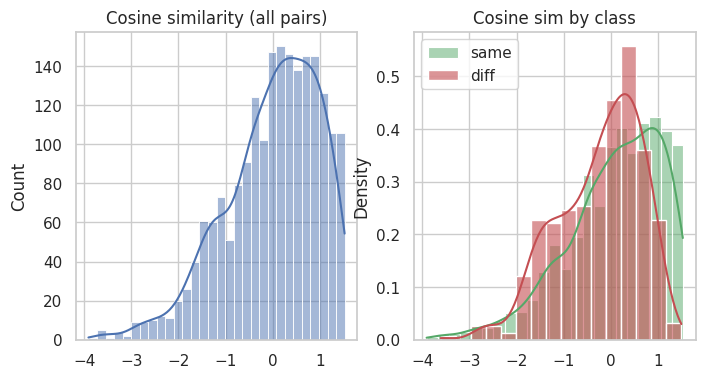

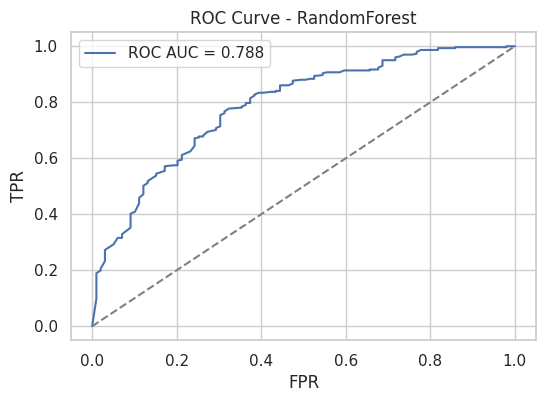

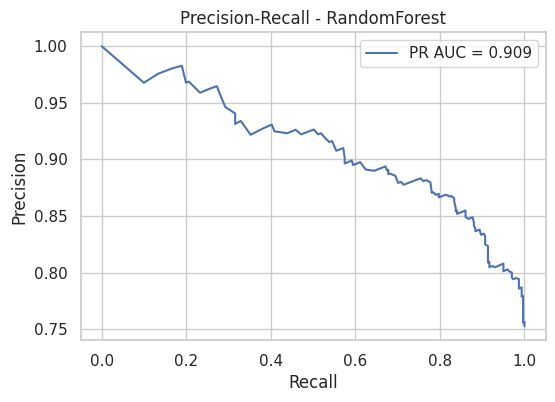

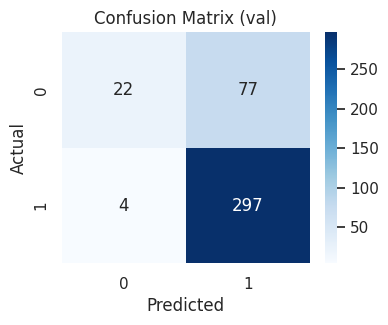

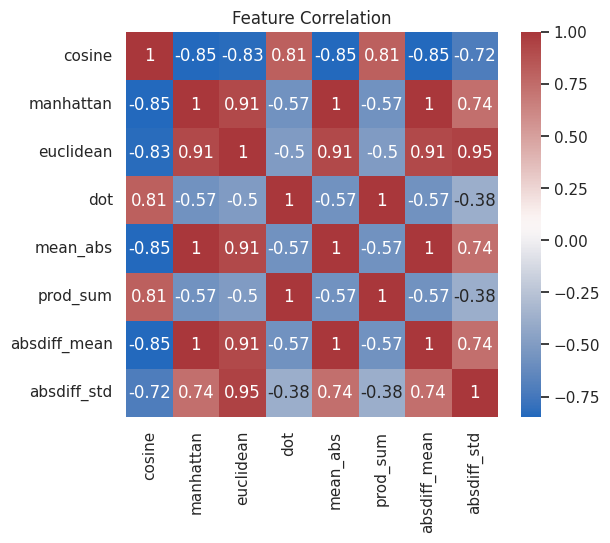

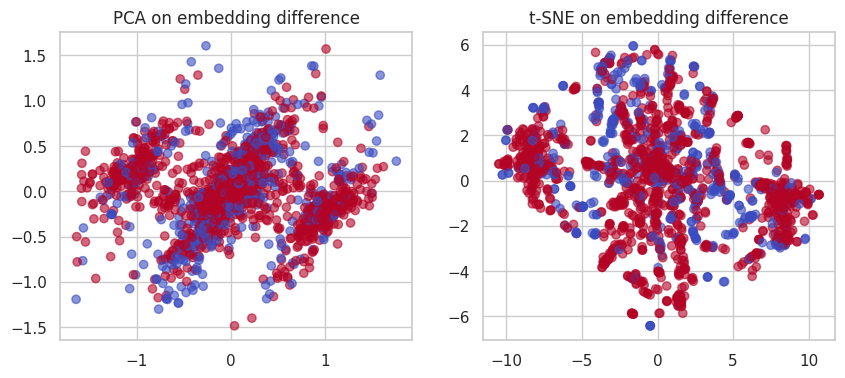

Encoding test set (may take time)...
Saved predictions to /content/test_predictions_enhanced.csv

Model comparison:
                Model   ROC AUC    PR AUC        F1  Accuracy  Precision  \
1        RandomForest  0.787996  0.909288  0.867624    0.7925   0.834356   
2             XGBoost  0.773113  0.901007  0.849673    0.7700   0.836013   
3            LightGBM  0.767475  0.904052  0.849359    0.7650   0.820433   
0  LogisticRegression  0.685426  0.876903  0.693957    0.6075   0.839623   

     Recall       MCC  
1  0.903654  0.398109  
2  0.863787  0.361741  
3  0.880399  0.322403  
0  0.591362  0.214377  


In [3]:
# Single cell: Improved InferSent pipeline + richer features + metrics + visualizations
# Run on Kaggle or Colab. May take a while the first time to download embeddings (~2GB).

# -----------------------
# 0) Install deps (if needed)
# -----------------------
!pip install kagglehub nltk matplotlib seaborn scikit-learn xgboost lightgbm --quiet

# -----------------------
# 1) Imports & Download dataset
# -----------------------
import os, shutil, re, zipfile, time
from io import BytesIO
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score, confusion_matrix,
                             classification_report, matthews_corrcoef, roc_curve,
                             precision_recall_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
nltk.download('punkt')

# Kaggle dataset fetch (kagglehub)
import kagglehub
path = kagglehub.dataset_download("rishisankineni/text-similarity")
print("Dataset downloaded to:", path)

# copy to /content/text-similarity (works in Colab/Kaggle)
src_path = path
dst_path = "/content/text-similarity"
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

train_df = pd.read_csv("/content/text-similarity/train.csv")
test_df = pd.read_csv("/content/text-similarity/test.csv")
print("Train:", train_df.shape, "Test:", test_df.shape)

# -----------------------
# 2) Clean text
# -----------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df = train_df.dropna(subset=["description_x", "description_y"]).copy()
test_df = test_df.dropna(subset=["description_x", "description_y"]).copy()

train_df["desc1_clean"] = train_df["description_x"].apply(clean_text)
train_df["desc2_clean"] = train_df["description_y"].apply(clean_text)
test_df["desc1_clean"] = test_df["description_x"].apply(clean_text)
test_df["desc2_clean"] = test_df["description_y"].apply(clean_text)

train_df.to_csv("/content/train_clean.csv", index=False)
test_df.to_csv("/content/test_clean.csv", index=False)
print("Cleaned and saved cleaned CSVs.")

# -----------------------
# 3) InferSent class (your implementation)
# -----------------------
import torch
import torch.nn as nn

class InferSent(nn.Module):
    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']
        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)
        if self.version == 1:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<s>', '</s>', True, False
        elif self.version == 2:
            self.bos, self.eos, self.max_pad, self.moses_tok = '<p>', '</p>', False, True

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        return word_tokenize(s)

    def get_word_dict(self, sentences):
        word_dict = {}
        for sent in sentences:
            for word in self.tokenize(sent):
                word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), "Model has no w2v_path set"
        with open(self.w2v_path, encoding='utf-8', errors='ignore') as f:
            k, word_vec = 0, {}
            for line in f:
                parts = line.rstrip().split(' ')
                word = parts[0]
                vec = ' '.join(parts[1:])
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    break
        return word_vec

    def build_vocab_k_words(self, K):
        print("Building word vectors from:", getattr(self, 'w2v_path', 'NOT SET'))
        self.word_vec = self.get_w2v_k(K)
        print("✅ Vocabulary built:", len(self.word_vec))

    def encode(self, sentences, bsize=64):
        sentences = [[self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        lengths = np.array([len(s) for s in sentences])
        idx_sort = np.argsort(-lengths)
        sentences = np.array(sentences, dtype=object)[idx_sort]
        lengths_sorted = lengths[idx_sort]

        def get_batch(batch):
            embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))
            for i in range(len(batch)):
                for j in range(len(batch[i])):
                    embed[j, i, :] = self.word_vec.get(batch[i][j], np.zeros(self.word_emb_dim))
            return torch.FloatTensor(embed)

        embeddings = []
        for i in range(0, len(sentences), bsize):
            batch = get_batch(sentences[i:i+bsize])
            sent_len_sorted = lengths_sorted[i:i+bsize]
            sent_packed = nn.utils.rnn.pack_padded_sequence(batch, sent_len_sorted)
            sent_output = self.enc_lstm(sent_packed)[0]
            sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]
            emb = torch.max(sent_output, 0)[0]  # max pooling
            embeddings.append(emb.detach().numpy())

        embeddings = np.vstack(embeddings)
        embeddings = embeddings[np.argsort(idx_sort)]
        return embeddings

# -----------------------
# 4) Download InferSent checkpoint + fastText if missing
# -----------------------
os.makedirs("encoder", exist_ok=True)
os.makedirs("fastText", exist_ok=True)

if not os.path.exists("encoder/infersent2.pkl"):
    print("Downloading InferSent checkpoint...")
    r = requests.get("https://dl.fbaipublicfiles.com/infersent/infersent2.pkl", stream=True)
    open("encoder/infersent2.pkl","wb").write(r.content)
    print("Downloaded infersent2.pkl")

# fastText: we'll attempt to download the common crawl 300d vec (note: ~2GB)
fasttext_path = "fastText/crawl-300d-2M.vec"
if not os.path.exists(fasttext_path):
    print("Downloading fastText vectors (this is large, may take many minutes)...")
    ft_zip_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
    r = requests.get(ft_zip_url, stream=True)
    with zipfile.ZipFile(BytesIO(r.content)) as z:
        z.extractall("fastText/")
    print("fastText downloaded and extracted.")

# -----------------------
# 5) Init model and build vocab (K selected to limit memory/time)
# -----------------------
params = {'bsize':64,'word_emb_dim':300,'enc_lstm_dim':2048,'pool_type':'max','dpout_model':0.0,'version':2}
model = InferSent(params)
model.load_state_dict(torch.load("encoder/infersent2.pkl", map_location=torch.device('cpu')))

# assign path & build vocab (limit K to speed up; increase if you can)
model.w2v_path = fasttext_path
K = 100000  # number of words to load from fastText (reduce to 50000 if memory/time tight)
model.build_vocab_k_words(K)

# -----------------------
# 6) Prepare subset (safe default) and encode sentences
# -----------------------
# Use a subset so it runs quickly. To run full data set, set subset = len(train_df)
subset = min(2000, len(train_df))  
print(f"Using subset = {subset} for training/validation (reduces runtime).")

s1 = train_df['desc1_clean'].head(subset).tolist()
s2 = train_df['desc2_clean'].head(subset).tolist()
y = train_df['same_security'].head(subset).astype(int).tolist()

print("Encoding sentences (this will take some time)...")
t0 = time.time()
emb1 = model.encode(s1, bsize=128)
emb2 = model.encode(s2, bsize=128)
print(f"Encoded {len(emb1)} sentences in {time.time()-t0:.1f}s")

# -----------------------
# 7) Feature engineering (expanded)
# -----------------------
def build_features(a, b):
    feats = []
    for x, y in zip(a, b):
        cos = 1 - distance.cosine(x, y) if (np.any(x) and np.any(y)) else 0.0
        man = distance.cityblock(x, y)
        euc = distance.euclidean(x, y)
        dot = np.dot(x, y)
        mean_abs = np.mean(np.abs(x - y))
        prod_sum = np.sum(x * y)
        # element-wise abs diff vector summary stats (optional)
        abs_diff_mean = np.mean(np.abs(x - y))
        abs_diff_std = np.std(np.abs(x - y))
        feats.append([cos, man, euc, dot, mean_abs, prod_sum, abs_diff_mean, abs_diff_std])
    return np.array(feats)

X = build_features(emb1, emb2)
feature_names = ["cosine","manhattan","euclidean","dot","mean_abs","prod_sum","absdiff_mean","absdiff_std"]
print("Feature matrix shape:", X.shape)

# -----------------------
# 8) Scale + train/validate split (stratified)
# -----------------------
from sklearn.model_selection import StratifiedKFold
X = np.nan_to_num(X)  # safety
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)

# -----------------------
# 9) Train multiple classifiers (LR, RandomForest, XGBoost/LightGBM if available)
# -----------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
models = {}
models['LogisticRegression'] = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
models['RandomForest'] = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

# add XGBoost if available
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=200)
except Exception as e:
    print("XGBoost not available or failed import:", e)

# add LightGBM if available
try:
    import lightgbm as lgb
    models['LightGBM'] = lgb.LGBMClassifier(random_state=42, n_estimators=200)
except Exception as e:
    print("LightGBM not available or failed import:", e)

# Fit models and collect performance
results = {}
for name, clf in models.items():
    print(f"\nTraining {name} ...")
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_val)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)
    results[name] = {
        'model': clf,
        'y_proba': y_proba,
        'y_pred': y_pred,
        'roc_auc': roc_auc_score(y_val, y_proba),
        'pr_auc': average_precision_score(y_val, y_proba),
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred, zero_division=0),
        'recall': recall_score(y_val, y_pred, zero_division=0),
        'f1': f1_score(y_val, y_pred, zero_division=0),
        'mcc': matthews_corrcoef(y_val, y_pred)
    }
    print(f"{name} ROC AUC: {results[name]['roc_auc']:.4f}, PR AUC: {results[name]['pr_auc']:.4f}, F1: {results[name]['f1']:.4f}")

# -----------------------
# 10) Choose best model by ROC AUC and tune threshold using Youden or max F1
# -----------------------
best_name = max(results.keys(), key=lambda n: results[n]['roc_auc'])
best = results[best_name]['model']
best_proba = results[best_name]['y_proba']
print(f"\nBest model (by ROC AUC): {best_name}")

# Find threshold maximizing F1 on validation
precisions, recalls, thresholds_pr = precision_recall_curve(y_val, best_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds_pr[best_idx] if best_idx < len(thresholds_pr) else 0.5
print(f"Chosen probability threshold (max F1 on val): {best_threshold:.3f}")

# Recompute final val metrics at chosen threshold
y_val_pred = (best_proba >= best_threshold).astype(int)
print("\nFINAL VALIDATION METRICS (best model):")
print("ROC AUC:", roc_auc_score(y_val, best_proba))
print("PR AUC:", average_precision_score(y_val, best_proba))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall:", recall_score(y_val, y_val_pred, zero_division=0))
print("F1:", f1_score(y_val, y_val_pred, zero_division=0))
print("MCC:", matthews_corrcoef(y_val, y_val_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, zero_division=0))

# -----------------------
# 11) Visualizations
# -----------------------
sns.set(style="whitegrid")
plt.figure(figsize=(8,4))
# Cosine distribution by class
cos_idx = feature_names.index("cosine")
plt.subplot(1,2,1)
sns.histplot(X_scaled[:, cos_idx], kde=True, bins=30)
plt.title("Cosine similarity (all pairs)")

plt.subplot(1,2,2)
sns.histplot(X_scaled[y==1, cos_idx], color='g', label='same', kde=True, stat='density')
sns.histplot(X_scaled[y==0, cos_idx], color='r', label='diff', kde=True, stat='density', alpha=0.6)
plt.legend()
plt.title("Cosine sim by class")
plt.show()

# ROC curve for best model
fpr, tpr, _ = roc_curve(y_val, best_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_val, best_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC Curve - {best_name}")
plt.legend(); plt.show()

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_val, best_proba)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"PR AUC = {average_precision_score(y_val, best_proba):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision-Recall - {best_name}")
plt.legend(); plt.show()

# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (val)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# Feature correlation heatmap
feat_df = pd.DataFrame(X_scaled, columns=feature_names)
plt.figure(figsize=(6,5))
sns.heatmap(feat_df.corr(), annot=True, cmap="vlag")
plt.title("Feature Correlation")
plt.show()

# PCA and t-SNE of embedding differences (for visualization)
try:
    emb_diff = emb1 - emb2
    pca = PCA(n_components=2).fit_transform(emb_diff)
    tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42).fit_transform(emb_diff)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.scatter(pca[:,0], pca[:,1], c=y, cmap="coolwarm", alpha=0.6)
    plt.title("PCA on embedding difference")
    plt.subplot(1,2,2)
    plt.scatter(tsne[:,0], tsne[:,1], c=y, cmap="coolwarm", alpha=0.6)
    plt.title("t-SNE on embedding difference")
    plt.show()
except Exception as e:
    print("PCA/t-SNE visualization failed:", e)

# -----------------------
# 12) Inference on test set and save predictions
# -----------------------
print("Encoding test set (may take time)...")
emb1_test = model.encode(test_df['desc1_clean'].tolist(), bsize=128)
emb2_test = model.encode(test_df['desc2_clean'].tolist(), bsize=128)
X_test = build_features(emb1_test, emb2_test)
X_test_scaled = scaler.transform(X_test)
test_proba = best.predict_proba(X_test_scaled)[:,1]
test_pred_labels = (test_proba >= best_threshold).astype(int)

test_df["pred_proba"] = test_proba
test_df["pred_same_security"] = test_pred_labels
out_path = "/content/test_predictions_enhanced.csv"
test_df.to_csv(out_path, index=False)
print("Saved predictions to", out_path)

# -----------------------
# 13) Summary table of model comparison
# -----------------------
summary = []
for name, v in results.items():
    summary.append([name, v['roc_auc'], v['pr_auc'], v['f1'], v['accuracy'], v['precision'], v['recall'], v['mcc']])
summary_df = pd.DataFrame(summary, columns=["Model","ROC AUC","PR AUC","F1","Accuracy","Precision","Recall","MCC"]).sort_values("ROC AUC", ascending=False)
print("\nModel comparison:")
print(summary_df)
